# Introduction to the Gaussian process regression 
## The Practice ploblem


Course
- SURF 2016

Lecturer :
- Georgios Karagiannis, Department of Mathematics, Purdue

July 8, 2016

Objective :

- We wish to build a Gaussian Process regression --a probabilistic surrogate model-- in order to be able to emulate the output of the Piston Simulator, with respect to specified inputs.

Related material:

    Readings :
    
    - Rasmussen, Carl Edward. "Gaussian processes in machine learning." In Advanced lectures on machine learning, pp. 63-71. Springer Berlin Heidelberg, 2004. 	
        - see http://www.GaussianProcess.org/gpml
        - Chapters: 2, 4, 5.1, & 5.4.2

    - Slides provided
    
    Software :
    
    - R-cran (https://cran.r-project.org/)
    - R packages 
        - DiceKrigin (https://cran.r-project.org/web/packages/DiceKriging/index.html)
        - lhs (https://cran.r-project.org/web/packages/lhs/index.html)
    - Roustant, Olivier, David Ginsbourger, and Yves Deville. "DiceKriging, DiceOptim: Two R packages for the analysis of computer experiments by kriging-based metamodeling and optimization." (2012).
        - Plus dependences ...

# The Piston Simulation function model

The Piston Simulation function models the circular motion of a piston within a cylinder. It involves a chain of nonlinear functions. 

The response C is cycle time (the time it takes to complete one cycle), in seconds. 

$$
C(x) = 2\pi \sqrt{\frac{M}{k+S^2}\frac{P_0 V_0}{T_0}\frac{T_0}{V^2}}
$$

$$
V = \frac{S}{2k} ( \sqrt{A^2 +4k\frac{P_0 V_0}{T_0}T_a} -A)
$$

$$
A = P_0 S 19.62M-\frac{kV_0}{S}
$$

The input variables and their usual input ranges are: 
<pre>

--------------------------------------------------
M  ∈ [30, 60]        | piston weight (kg)
S  ∈ [0.005, 0.020]  | piston surface area (m2)
V0 ∈ [0.002, 0.010]  | initial gas volume (m3)
k  ∈ [1000, 5000]    | spring coefficient (N/m)
P0 ∈ [90000, 110000] | atmospheric pressure (N/m2)
Ta ∈ [290, 296]      | ambient temperature (K)
T0 ∈ [340, 360]      | filling gas temperature (K)
--------------------------------------------------

</pre>

Here, we consider the output in the log scale.

=> As a result we wish to emulate the function f(M, S, V0 k, P0, Ta, T0) := log(C(M, S, V0 k, P0, Ta, T0)).

Reference:
http://www.sfu.ca/~ssurjano/piston.html

Kenett, R., & Zacks, S. (1998). Modern industrial statistics: design and control of quality and reliability. Pacific Grove, CA: Duxbury press.




## Software preparation

In [1]:
# DOWNLOAD THE R PACKAGES REQUIRED
install.packages('DiceKriging', repos = "http://cran.us.r-project.org")
install.packages('lhs', repos = "http://cran.us.r-project.org")
# install.packages('tcltk', repos = "http://cran.us.r-project.org")
# install.packages('aplpack', repos = "http://cran.us.r-project.org")

Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("DiceKriging", repos = "http://cran.us.r-project.org"): installation of package ‘DiceKriging’ had non-zero exit statusInstalling package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Installing package into ‘/export/users/gkaragia/R/x86_64-redhat-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)
Warning message:
In install.packages("lhs", repos = "http://cran.us.r-project.org"): installation of package ‘lhs’ had non-zero exit status

In [1]:
# LOAD THE R PACKAGES REQUIRED
library('lhs')
library('DiceKriging')
# library('tcltk')
# library('aplpack')

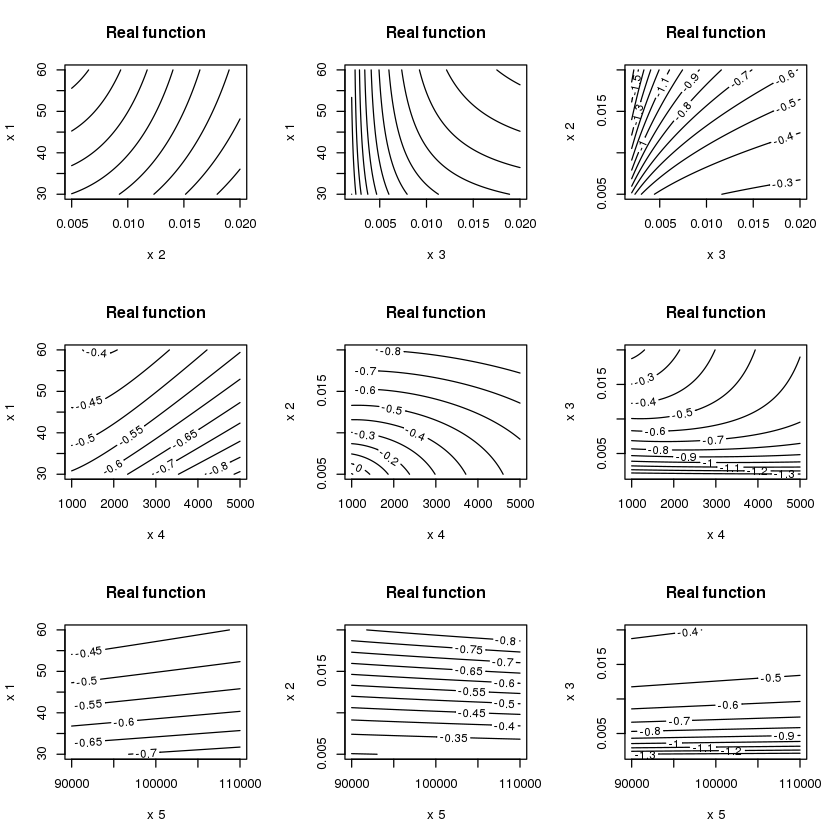

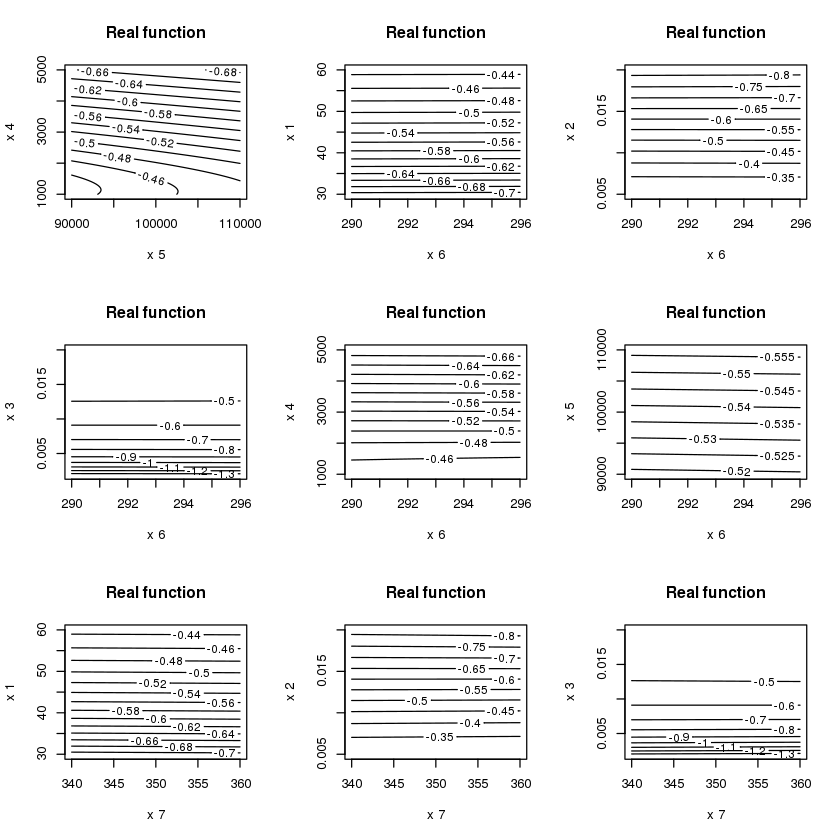

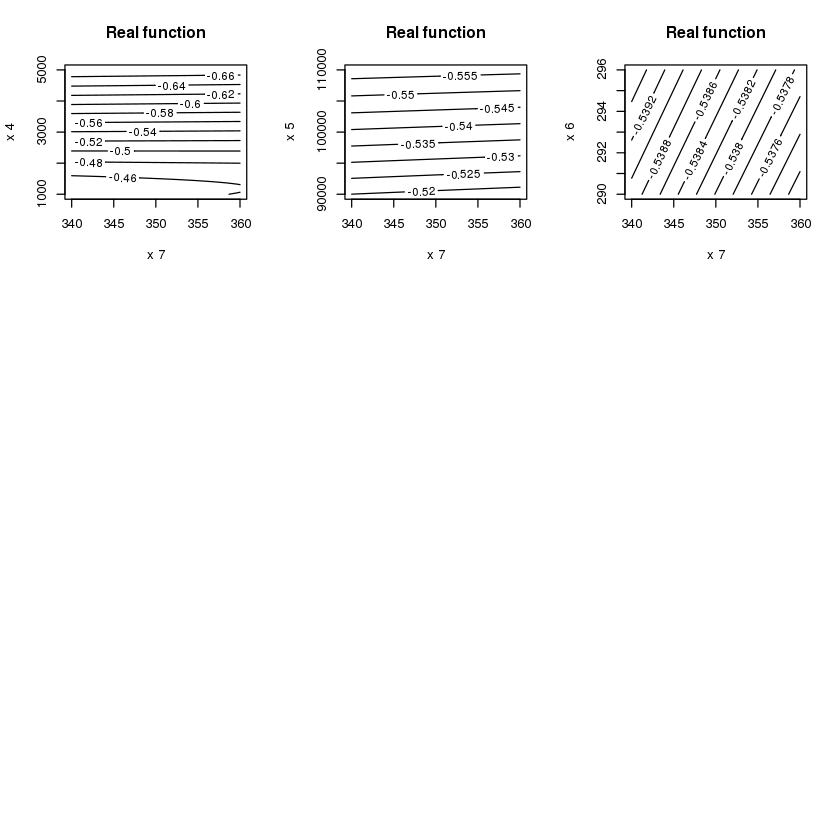

In [113]:
# THIS IS THE SIMULATOR AND THE MIN AND MAX OF THE INPUTS

piston <- function(xx) {
  ##########################################################################
  #
  # PISTON FUNCTION
  #
  # Authors: Sonja Surjanovic, Simon Fraser University
  #          Derek Bingham, Simon Fraser University
  # Questions/Comments: Please email Derek Bingham at dbingham@stat.sfu.ca.
  #
  # Copyright 2013. Derek Bingham, Simon Fraser University.
  #
  # THERE IS NO WARRANTY, EXPRESS OR IMPLIED. WE DO NOT ASSUME ANY LIABILITY
  # FOR THE USE OF THIS SOFTWARE.  If software is modified to produce
  # derivative works, such modified software should be clearly marked.
  # Additionally, this program is free software; you can redistribute it 
  # and/or modify it under the terms of the GNU General Public License as 
  # published by the Free Software Foundation; version 2.0 of the License. 
  # Accordingly, this program is distributed in the hope that it will be 
  # useful, but WITHOUT ANY WARRANTY; without even the implied warranty 
  # of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU 
  # General Public License for more details.
  #
  # For function details and reference information, see:
  # http://www.sfu.ca/~ssurjano/
  #
  ##########################################################################
  #
  # OUTPUT AND INPUT:
  #
  # C = cycle time
  # xx = c(M, S, V0, k, P0, Ta, T0)
  #
  ##########################################################################
  
  M  <- xx[1]
  S  <- xx[2]
  V0 <- xx[3]
  k  <- xx[4]
  P0 <- xx[5]
  Ta <- xx[6]
  T0 <- xx[7]
  
  Aterm1 <- P0 * S
  Aterm2 <- 19.62 * M
  Aterm3 <- -k*V0 / S
  A <- Aterm1 + Aterm2 + Aterm3
  
  Vfact1 <- S / (2*k)
  Vfact2 <- sqrt(A^2 + 4*k*(P0*V0/T0)*Ta)
  V <- Vfact1 * (Vfact2 - A)
  
  fact1 <- M
  fact2 <- k + (S^2)*(P0*V0/T0)*(Ta/(V^2))
  
  C <- 2 * pi * sqrt(fact1/fact2)
  return(C)
}
input_min <- c(30, 0.005, 0.002, 1000, 90000, 290, 340 )
input_max <- c(60, 0.020, 0.020, 5000, 110000, 296, 360 )
input_d <- length(input_min)

myfun <- function(xx) {return(log(piston(xx))) }

# PLOT THE REAL FUNCTION TO SEE HOW IT LOOKS LIKE

par(mfrow = c(3,3))
for (i in 1:input_d) {
    for ( j in 1:input_d ) 
        if(i>j) {
        n.grid <- 100 ;
        x1.grid <-seq(input_min[i],input_max[i],length.out=n.grid) ;
        x2.grid <-seq(input_min[j],input_max[j],length.out=n.grid) ;
        X.grid <- expand.grid( x1=x1.grid,  x2=x2.grid )
        myfun2d<-function(xx){ 
                            zz<-0.5*(input_min+input_max) ; 
                            zz[i]<-xx[1]; zz[j]<-xx[2]; 
                            return(myfun(zz)) 
                    }
        y.grid <- apply(X.grid,1,myfun2d)
    contour(x1.grid, x2.grid, matrix(y.grid, n.grid, n.grid), 10, 
            main = "Real function", 
            xlab = paste("x", as.character(i)), 
            ylab = paste("x", as.character(j)),
            xlim = c(input_min[i],input_max[i]), 
            ylim = c(input_min[j],input_max[j]))
    }
}

## Generate a training data-set

Generate a training data-set $D={(x_i,y_i);i=1,...,n}$  of size $n=20$ via a LHS.

## Compare different GP regression models

Use the diagnostics we leant, and compare Gaussian process regression models deffering on the prior linear trend structure or the covariance function

## Choose the 'Best' model

## Check the validity of the chossen 'Best' model

## Print the estimates of the hyperparameters

## Plot the posterior GPR mean and variance, as well as the real function (in contour plots)